# Identificador de fraudes

Aluno: Luís Felipe Ribeiro Chaves

NUSP: 10801221

## Questão 1

### a)
Baseado na base de dados fornecida, qual das duas métricas de avaliação
deve ser usada para medir os resultados dos modelos: Acurácia ou AUC?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import PowerTransformer
import random
random.seed(42)

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

dataset = train.append(test)
not_fraude, fraude = dataset['Class'].value_counts()

not_fraude, fraude, not_fraude / (fraude + not_fraude)

(284315, 492, 0.9982725143693799)

Podemos perceber que a quantidade de fraudes é ínfima comparada à quantidade total de operações. Isso implica que utilizar a acurácia como métrica não será legal, pois o modelo seria tentado a somente chutar que não é fraude em todas as classificações e para conseguir uma altíssima acurácia de 99.82%.

### b)
Na base fornecida, qual seria o resultado esperado de um modelo aleatório para cada uma das duas métricas (Acurácia e AUC)?

Para acurácia:

In [5]:
def aleatorio(output_column, p=0.5):
    total = output_column.count()
    acerto = 0

    for output in output_column:
        prediction = random.choices((0, 1), (p, 1 - p))[0]
        if output == prediction:
            acerto += 1

    return acerto / total

output_column = dataset['Class']
print('p 0.15:', aleatorio(output_column, 0.15))
print('p 0.50:', aleatorio(output_column, 0.50))
print('p 0.75:', aleatorio(output_column, 0.75))

p 0.15: 0.1520784250387104
p 0.50: 0.50013166811209
p 0.75: 0.750680285245798


Sendo p a chance de classificar que uma compra como não fraude, percebe-se que a acurácia aproxima-se de p

AUC:

AUC normal com centro_normal 0.15: 0.5129278057988185
AUC normal com centro_normal 0.50: 0.4890360571386168
AUC normal com centro_normal 0.75: 0.5012921550570341
AUC uniforme: 0.4795490273369926


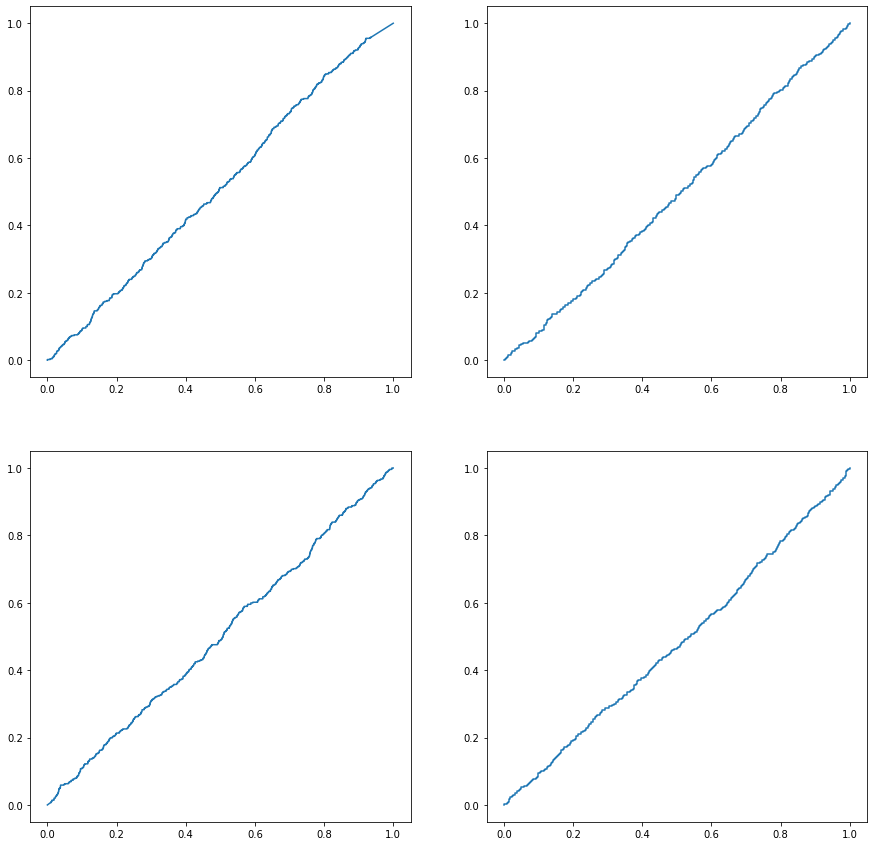

In [6]:
def aleatorio_auc(output_column, centro_normal=0.5, random_type='normal'):
    random_outputs = None
    if random_type == 'normal':
        random_outputs = np.random.normal(0, 1, output_column.shape)
    
        mini, maxi = random_outputs.min(), random_outputs.max()
        diff = maxi - mini

        random_outputs = (random_outputs - mini) / diff

        centro_normal -= 0.5
        random_outputs += centro_normal
        random_outputs = np.clip(random_outputs, 0, 1)
    elif random_type == 'uniform':
        random_outputs = np.random.random(output_column.shape)

    fp_ratio, tp_ratio, thresholds = metrics.roc_curve(output_column, random_outputs)
    
    return fp_ratio, tp_ratio, thresholds, metrics.auc(fp_ratio, tp_ratio)

figure, axis = plt.subplots(2, 2)
figure.set_figwidth(15)
figure.set_figheight(15)

fp_ratio, tp_ratio, thresholds, auc = aleatorio_auc(output_column, 0.15)
axis[0][0].plot(fp_ratio, tp_ratio)
print('AUC normal com centro_normal 0.15:', auc)

fp_ratio, tp_ratio, thresholds, auc = aleatorio_auc(output_column, 0.50)
axis[0][1].plot(fp_ratio, tp_ratio)
print('AUC normal com centro_normal 0.50:', auc)

fp_ratio, tp_ratio, thresholds, auc = aleatorio_auc(output_column, 0.75)
axis[1][0].plot(fp_ratio, tp_ratio)
print('AUC normal com centro_normal 0.75:', auc)

fp_ratio, tp_ratio, thresholds, auc = aleatorio_auc(output_column, random_type='uniform')
axis[1][1].plot(fp_ratio, tp_ratio)
print('AUC uniforme:', auc)

O resultado da AUC fica próximo de 0.5 independente do modelo aleatório gerado

### Questão 2

Usando a classe MLPClassifier do scikit-learn crie a seguinte arquitetura de rede
neural:
- 5 camadas escondidas, com 20 neurônios em cada camada;
- Função de ativação ReLU para todos os neurônios das camadas escondidas;
- random_state = 42 e
- Os demais parâmetros com o valor padrão da classe MLPClassifier.

Em seguida, treine um modelo para cada um dos valores de alpha (taxa de
regularização L2): [0.0, 0.01, 0.1, 1, 10] e compute o resultado deles na
base de teste (usando a métrica escolhida na questão anterior).
Com base nesses resultados, comente sobre o efeito da taxa de regularização no
resultado do modelo.

In [7]:
def calculate_auc(model, x_test, y_test):
    predicted_proba = model.predict_proba(x_test)
    fp_ratio, tp_ratio, thresholds = metrics.roc_curve(y_test, predicted_proba[:,1])
    
    return metrics.auc(fp_ratio, tp_ratio), fp_ratio, tp_ratio, thresholds

In [8]:
x_train, y_train = train.drop('Class', 1), train['Class']
x_test, y_test = test.drop('Class', 1), test['Class']

AUC para alpha 0: 0.9117608765999267
AUC para alpha 0.01: 0.9197228990977773
AUC para alpha 0.1: 0.9817249592665648
AUC para alpha 1: 0.9820028549675237
AUC para alpha 10: 0.18039316674940564


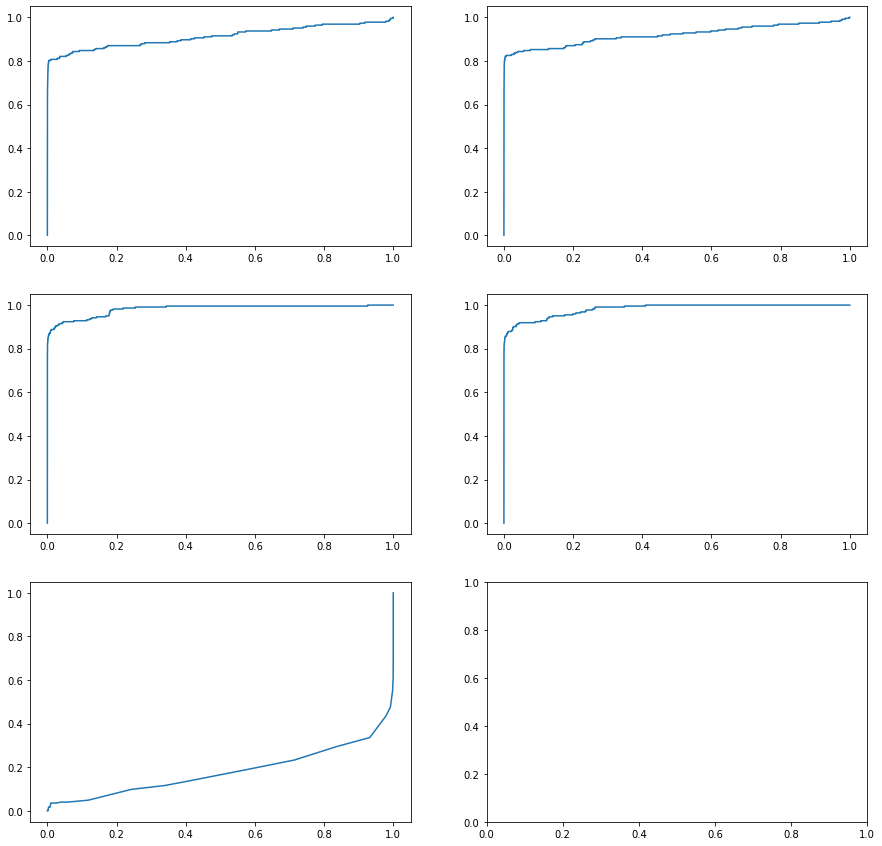

In [7]:
models = []
models_fpr = []
models_tpr = []

for alpha in (0, 0.01, 0.1, 1, 10):
    model = MLPClassifier(hidden_layer_sizes=(20,) * 5, activation='relu', random_state=42, alpha=alpha)
    model.fit(x_train, y_train)
    
    
    auc, fp_ratio, tp_ratio, thresholds = calculate_auc(model, x_test, y_test)
    print(f'AUC para alpha {alpha}:', auc)
    
    models_fpr.append(fp_ratio)
    models_tpr.append(tp_ratio)
    models.append(model)
    
figure, axis = plt.subplots(3, 2)
figure.set_figwidth(15)
figure.set_figheight(15)

for i in range(len(models)):
    axis[i // 2][i % 2].plot(models_fpr[i], models_tpr[i])

Com os valores e gráficos acima, podemos perceber que aumentar o alpha provou-se muito benéfico até um certo limite, depois desandou muito. 

Quanto maior o alpha, mais a rede neural é incentivada a não utilizar muitos pesos/neurônios e isso é perfeito para evitar overfitting da base de treino. Pense: Se você der para um modelo todos os neurônios e pesos que ele quiser para aprender uma base de treino, ele com certeza vai overfittar pra acertar absolutamente todas as entradas, mesmo que precise usar diversos pesos e neurônios para acertar apenas uma ou duas entradas que podem ser ruídos. Agora, se você der uma penalidade para o uso desnecessário de pesos/neurônios, não compensará a utilização de muitos neurônios e pesos para acertar apenas uma ou duas entradas, o que certamente diminuirá a influencia de ruído.

Abaixo podemos ver na prática que, ao aumentar o alfa, a quantidade de pesos próximos de zero diminui bastante. Vejamos abaixo a contagem de zeros nos pesos resultantes

In [8]:
delta = 0.0001
print('Total de pesos:', 28 * 20 + 20**2 * 4 + 20 * 1)
for model in models:
    layers = model.coefs_
    amount_of_zeros = 0
    for layer in layers:
        amount_of_zeros += np.sum(np.abs(layer) <= delta)
    print(f'Número de pesos próximos de 0 para alpha: {model.alpha}:', amount_of_zeros)

Total de pesos: 2180
Número de pesos próximos de 0 para alpha: 0: 0
Número de pesos próximos de 0 para alpha: 0.01: 635
Número de pesos próximos de 0 para alpha: 0.1: 962
Número de pesos próximos de 0 para alpha: 1: 1104
Número de pesos próximos de 0 para alpha: 10: 1726


### Questão 3

Compare os seguintes modelos:
1. Rede neural (MLPClassifier):
    1. Sem camadas intermediárias;
    2. Com uma camada intermediária de 10 neurônios e
    3. Com duas camadas, com 5 neurônios cada.
2. K-NN (KNeighborsClassifier)
    1. Com k = 3;
    2. Com k = 5 e
    3. Com k = 7.

Todos os demais hiperparâmetros devem ser deixados com os valores padrão do scikit-learn. Essa comparação deve ser feita usando 3-fold cross-validation nos dados de treinamento. Por fim, o valor da métrica de sucesso na base de teste só deve ser computado para o melhor modelo de rede neural e o melhor K-NN. Tal protocolo deve ser seguido para que tenhamos uma estimativa mais robusta dos resultados dos modelos.

Com base nesses resultados, responda:
1. Qual técnica obteve o melhor resultado na base de teste?
2. Qual técnica demora mais para gerar as previsões nos dados de teste?

Dicas:
1. Use a classe GridSearchCV do scikit-learn para comparar os hiperparâmetros e
2. Use o magic command %%time do Jupyter Notebook para medir os tempos.

In [9]:
%%time

grid_mlp = GridSearchCV(MLPClassifier(), { 'hidden_layer_sizes': (tuple(), (10,), (5,5)) }, cv=3, scoring='roc_auc')
grid_mlp.fit(x_train, y_train)

CPU times: user 37.6 s, sys: 2.36 s, total: 40 s
Wall time: 36.9 s


GridSearchCV(cv=3, estimator=MLPClassifier(),
             param_grid={'hidden_layer_sizes': ((), (10,), (5, 5))},
             scoring='roc_auc')

In [10]:
%%time

grid_knn = GridSearchCV(KNeighborsClassifier(), { 'n_neighbors': (3, 5, 7) }, cv=3, scoring='roc_auc')
grid_knn.fit(x_train, y_train)

CPU times: user 13min 58s, sys: 7min 11s, total: 21min 10s
Wall time: 11min 20s


GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': (3, 5, 7)}, scoring='roc_auc')

In [11]:
grid_mlp.best_params_, grid_knn.best_params_

({'hidden_layer_sizes': (5, 5)}, {'n_neighbors': 7})

Utilizando o GridSearchCV, podemos perceber que os melhores parametros para o modelo de redes neurais é 1 camadas com 10 neurônios cada e, para o knn, 3 vizinhos.

In [12]:
%%time

calculate_auc(grid_mlp.best_estimator_, x_test, y_test)[0]

CPU times: user 225 ms, sys: 345 ms, total: 570 ms
Wall time: 114 ms


0.9416939116524433

In [13]:
%%time

calculate_auc(grid_knn.best_estimator_, x_test, y_test)[0]

CPU times: user 7min 40s, sys: 3min 35s, total: 11min 15s
Wall time: 5min 46s


0.9142381885653693

Podemos perceber que o classificador com redes neurais deu um coro no knn. O tempo de treinamento foi cerca de 30x menor que o knn, O tempo para classificar a base de testes foi 1000x menor e ainda acertou mais.

In [14]:
model = grid_mlp.best_estimator_

### Questão 4

Usando o melhor modelo obtido na questão anterior, calcule o lucro que tal
modelo traria no seguinte cenário:
- As top-1% transações com maior chance de fraude (de acordo com os scores do modelo) seriam impedidas de acontecer;
- Cada fraude evitada em média evita um prejuízo (gera um lucro) de RS 100 e
- Cada não-fraude bloqueada gera em média um prejuízo de 2 reais.

In [15]:
predicted_proba = pd.DataFrame(model.predict_proba(x_test)).drop(columns=[0])

top1 = predicted_proba.quantile(0.99)

predicted_proba[predicted_proba >= top1] = 1
predicted_proba[predicted_proba < top1] = 0

confusion_m = metrics.confusion_matrix(y_test, predicted_proba)
confusion_m

array([[140943,   1237],
       [    35,    188]])

A matriz de confusão acima aparentemente está invertida.
- 0,0 Casos classificados como não fraude corretamente
- 0,1 Casos classificados como fraude incorretamente
- 1,0 Casos classificados como não fraude incorretamente
- 1,1 Casos classificados como fraude corretamente

O lucro encontra-se abaixo

In [16]:
confusion_m[1][1] * 100 - confusion_m[0][1] * 2

16326

### Questão 5

Use uma rede neural sem camadas intermediárias e com um neurônio de saída
para encontrar variáveis não importantes para o problema estudado. Indique
porque tais variáveis não são importantes.

Dica: use a classe SGDClassifier(loss='log', random_state=42) para criar
uma rede com um só neurônio de saída que usa a função de ativação sigmoid.
Modifique os outros hiperparâmetros conforme necessário.

In [9]:
best_model, best_auc = None, 0
for alpha in (1e-07, 1e-06, 1e-05, 1e-04, 1e-03, 1e-02, 1e-01):
    model = SGDClassifier(loss='log', random_state=42, penalty='l1', alpha=alpha)
    model.fit(x_train, y_train)
    
    auc, fp_ratio, tp_ratio, thresholds = calculate_auc(model, x_test, y_test)
    print(f'AUC para alpha {alpha}:', auc)
    if auc > best_auc:
        best_auc = auc
        best_model = model

AUC para alpha 1e-07: 0.7747204484683408
AUC para alpha 1e-06: 0.8496223917512506
AUC para alpha 1e-05: 0.9178637639271131
AUC para alpha 0.0001: 0.8100742159089691
AUC para alpha 0.001: 0.6934761216597163
AUC para alpha 0.01: 0.7002560229658987
AUC para alpha 0.1: 0.5


Aparentemente alpha = 1e-05 obeteve o melhor resultado. O fato de o alpha ser baixo vai implicar numa menor chance de que haja coeficientes com peso 0.

In [10]:
model = best_model

model.coef_

array([[  27.22493111,   51.75907269,   34.05720235,  100.57630028,
          -5.69522431,  -39.28067118,  -18.13416495,   11.33406204,
        -100.01494088,  -35.86042249,  -51.1706712 ,   88.14426058,
        -112.51384885, -121.958809  ,   -8.11445643,   -1.85821207,
          -0.85005405,   11.24577874,  -32.40827769,   88.51218595,
          84.07854084,   83.50025127,   18.33813719,   -0.41117685,
         -39.13377995,   66.27372639, -151.84593478,   60.44324205]])

Aparentemente, mesmo utilizando regularização L1, nenhum peso ficou com valor 0 ou próximo de 0. Isso quer dizer que todas as variáveis contribuem para a predição e a remoção de qualquer uma delas com certeza acarretará em perda de informações.

Dito isso, abaixo é realizado uma análisa com a regularização L2, em que removemos metade dos atributos por vez (meio que uma busca binária manual) enquanto a AUC estiver decente. 

In [11]:
%%time

grid_sgd = GridSearchCV(
    SGDClassifier(loss='log', random_state=42, penalty='l2'),
    { 'alpha': (1e-07, 1e-06, 1e-05, 1e-04, 1e-03, 1e-02, 1e-01) },
    cv=3,
    scoring='roc_auc'
)
grid_sgd.fit(x_train, y_train)

CPU times: user 10.1 s, sys: 5.66 s, total: 15.8 s
Wall time: 8.32 s


GridSearchCV(cv=3, estimator=SGDClassifier(loss='log', random_state=42),
             param_grid={'alpha': (1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01,
                                   0.1)},
             scoring='roc_auc')

In [12]:
grid_sgd.best_params_

{'alpha': 0.01}

In [13]:
model = grid_sgd.best_estimator_

In [14]:
metrics.roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])

0.9807471360436811

Aparentemente alpha = 1e-07 obeteve o melhor resultado

In [15]:
coef = np.abs(model.coef_)
coef_norm = coef / np.linalg.norm(coef)
coef_norm = coef_norm[0]

quantile = np.quantile(coef_norm, 0.5)

Atualizando o x_train e x_test para conterem apenas as colunas selecionadas

In [16]:
x_train_filtered = x_train[x_train.columns.to_numpy()[coef_norm > quantile]]
x_test_filtered = x_test[x_test.columns.to_numpy()[coef_norm > quantile]]

In [17]:
model.fit(x_train_filtered, y_train)

metrics.roc_auc_score(y_test, model.predict_proba(x_test_filtered)[:, 1])

0.9784413365991571

O modelo piorou bem pouco! Vou cortar mais

In [18]:
quantile = np.quantile(coef_norm, 0.75)

x_train_filtered2 = x_train[x_train.columns.to_numpy()[coef_norm > quantile]]
x_test_filtered2 = x_test[x_test.columns.to_numpy()[coef_norm > quantile]]

model.fit(x_train_filtered2, y_train)

metrics.roc_auc_score(y_test, model.predict_proba(x_test_filtered2)[:, 1])

0.9772237806305025

Piorou muito pouco de novo, vou cortar mais

In [19]:
quantile = np.quantile(coef_norm, 0.875)

x_train_filtered3 = x_train[x_train.columns.to_numpy()[coef_norm > quantile]]
x_test_filtered3 = x_test[x_test.columns.to_numpy()[coef_norm > quantile]]

model.fit(x_train_filtered3, y_train)

metrics.roc_auc_score(y_test, model.predict_proba(x_test_filtered3)[:, 1])

0.970363847507139

In [20]:
quantile = np.quantile(coef_norm, 0.95)

x_train_filtered4 = x_train[x_train.columns.to_numpy()[coef_norm > quantile]]
x_test_filtered4 = x_test[x_test.columns.to_numpy()[coef_norm > quantile]]

model.fit(x_train_filtered4, y_train)

metrics.roc_auc_score(y_test, model.predict_proba(x_test_filtered4)[:, 1])

0.9517128858952872

95% com 2 variáveis já é um valor bem decente e já podiamos parar por aqui, mas vou cortar mais

In [21]:
quantile = np.quantile(coef_norm, 0.99)

x_train_filtered5 = x_train[x_train.columns.to_numpy()[coef_norm > quantile]]
x_test_filtered5 = x_test[x_test.columns.to_numpy()[coef_norm > quantile]]

model.fit(x_train_filtered5, y_train)

metrics.roc_auc_score(y_test, model.predict_proba(x_test_filtered5)[:, 1])

0.929423922306531

Utilizando somente 1 atributo a acurácia continuou muito alta, portanto aparentemente é possível remover 23/24 atributos. Isso significa que, apesar de todos os atributos conterem informações pertinentes, somente o o atributo 14 já tem significado suficiente para gerar uma boa classificação. Isso é bom pois torna o treinamento e classificação mais baratos

In [22]:
x_train_filtered5

,V14
0,-0.311169
1,-0.143772
2,-0.165946
3,-0.287924
4,-1.119670
...,...
142399,0.659657
142400,0.099373
142401,0.839671
142402,-0.386616
